In [1]:
# Libraries
# !pip install nilearn

import nibabel as nib
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU



In [2]:
# Paths and dataset

'''
    DIRECTORY STRUCTURE INSIDE MY KAGGLE

    home ('../')
        lib
            kaggle
                gcp.py
        input_png
            SISS2015_Training
                augmented
                    lesions
                    non_lesions
                [1-28] folders
        input
            siss2015small
                SISS2015_Training
                    [1-28] folders
        working
        

'''

TRAIN_DATASET_PATH = '../input/siss2015small/SISS2015_Training/'
PNG_PATH = '../input_png/'
PNG_TRAIN_DATASET_PATH = '../input_png/SISS2015_Training/'
AUG_PNG_TRAIN_DATASET_PATH = None

train_directories = [f.path+'/' for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_ids = train_directories.copy()
train_ids.sort()

# train_test_ids, val_ids = train_test_split(train_ids, test_size=0.2, shuffle=False)
# train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, shuffle=False)

VOLUME_SLICES = 153
VOLUME_START_AT = 0
IMG_SIZE=192



In [3]:
try:
    os.makedirs(PNG_TRAIN_DATASET_PATH, exist_ok=True)
except FileExistsError as e:
    print("Folder already exists!")

try:
    for i in range(1, 29):
        os.mkdir(PNG_TRAIN_DATASET_PATH + "{}/".format(str(i)))
except FileExistsError as e:
    print("Folder already exists!")



In [4]:
print("TOTAL TRAINING SAMPLES: ", )
print("SAMPLE 1: ", train_ids[0])

print("CURRENT WORKING DIRECTORY: ", os.getcwd())
print("CURRENT WORKING DIRECTORY ITEMS: ", os.listdir('../'))
print("PNG DATASET DIRECTORY ITEMS: ", os.listdir(PNG_TRAIN_DATASET_PATH))



TOTAL TRAINING SAMPLES: 
SAMPLE 1:  ../input/siss2015small/SISS2015_Training/1/
CURRENT WORKING DIRECTORY:  /kaggle/working
CURRENT WORKING DIRECTORY ITEMS:  ['lib', 'input_png', 'input', 'working']
PNG DATASET DIRECTORY ITEMS:  ['27', '22', '5', '23', '11', '6', '12', '24', '17', '20', '28', '18', '21', '4', '16', '10', '19', '26', '1', '25', '15', '9', '7', '3', '2', '8', '13', '14']


Path:  ../input_png/SISS2015_Training/1/
File Name:  1_1_slice_2.png
File Name with Path:  ../input_png/SISS2015_Training/1/1_1_slice_2.png
Dimensions of the image ../input_png/SISS2015_Training/1/1_1_slice_2.png: (256, 256)
Saved all PNGs for sample  1
Total PNGs for sample 1:  770
Saved all PNGs for sample  2
Saved all PNGs for sample  3
Saved all PNGs for sample  4
Saved all PNGs for sample  5
Saved all PNGs for sample  6
Saved all PNGs for sample  7
Saved all PNGs for sample  8
Saved all PNGs for sample  9
Saved all PNGs for sample  10
Saved all PNGs for sample  11
Saved all PNGs for sample  12
Saved all PNGs for sample  13
Saved all PNGs for sample  14
Saved all PNGs for sample  15
Saved all PNGs for sample  16
Saved all PNGs for sample  17
Saved all PNGs for sample  18
Saved all PNGs for sample  19
Saved all PNGs for sample  20
Saved all PNGs for sample  21
Saved all PNGs for sample  22
Saved all PNGs for sample  23
Saved all PNGs for sample  24
Saved all PNGs for sample  25
Save

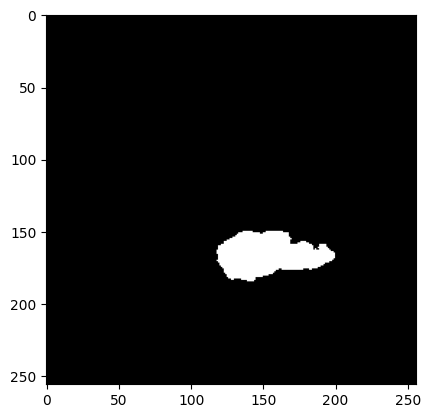

In [5]:
mod_dict = {
    1: ".MR_DWI.", 
    2: ".MR_Flair.", 
    3: ".MR_T1.", 
    4: ".MR_T2.", 
    5: ".OT." # MASK OUTPUT
}

TOTAL_TRAINING_SAMPLES = len(train_ids) #28
nii_counter = 70613
PADDED_IMG_SIZE = 256  # Target image size

def pad_image(image, target_size=PADDED_IMG_SIZE):
    """Pad the image to the target size."""
    h, w = image.shape
    pad_h = (target_size - h) // 2
    pad_w = (target_size - w) // 2

    padded_image = np.pad(image, 
                         ((pad_h, target_size - h - pad_h), 
                          (pad_w, target_size - w - pad_w)), 
                         mode='constant', constant_values=0)
    return padded_image

def nii_to_png():
    global nii_counter
    global TOTAL_TRAINING_SAMPLES
    for i in range(1, TOTAL_TRAINING_SAMPLES + 1):
        if i == 15:
            nii_counter = 70707
        if i == 16:
            nii_counter = 70717
        if i == 19:
            nii_counter = 70747
        if i == 20:
            nii_counter = 70761
        for j in range(1, len(mod_dict) + 1):
            if i == 16 and j == 3:
                nii_counter = 70725
            if i == 19 and j == 2:
                nii_counter = 70750
            if i == 19 and j == 3:
                nii_counter = 70753
            if i == 19 and j == 5:
                nii_counter = 70758
            if i == 20 and j == 2:
                nii_counter = 70768
            sample_path = "{}/VSD.Brain.XX.O{}{}".format(str(i), mod_dict[j], str(nii_counter))
            file_name = "/VSD.Brain.XX.O{}".format(mod_dict[j]) + str(nii_counter) + ".nii"
            data_path = os.path.join(TRAIN_DATASET_PATH + sample_path + file_name)
#             print(i, data_path)
            if j != 4:
                nii_counter += 1
            else:
                nii_counter += 2

            if os.path.exists(data_path):
                mri_image = nib.load(data_path).get_fdata()
#                 print("Total Slices: ", i, mri_image.shape[-1])
                for curr_slice in range(mri_image.shape[-1]): # Slice Values (153, 154)
                    slice_data = mri_image[..., curr_slice]
                    slice_data = pad_image(slice_data)
                    if i == 14 and curr_slice == 66: # Test Sample
                        plt.imshow(slice_data, cmap='gray')
                    sample_path = "{}/VSD.Brain.XX.O{}{}".format(str(i), mod_dict[j], str(nii_counter - 1 if j != 4 else 2))
                    file_name = "{}_{}_slice_{}.png".format(i, j, curr_slice + 1) # mod_dict[j][1:-1]
#                     png_path = os.path.join(PNG_TRAIN_DATASET_PATH + sample_path)
                    png_path = "{}{}/".format(PNG_TRAIN_DATASET_PATH, i)
                    if i == 1 and j == 1 and curr_slice == 1: # Test Sample
                        print("Path: ", png_path)
                        print("File Name: ", file_name)
                        print("File Name with Path: ", png_path + file_name)
                    try:
                        plt.imsave(png_path + file_name, slice_data, cmap='gray')
                        if i == 1 and j == 1 and curr_slice == 1: # Test Sample
                            # Path to the image
                            image_path = '../input_png/SISS2015_Training/1/1_1_slice_2.png'
                            # Load the image using OpenCV
                            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                            # Check if the image was loaded successfully
                            if image is not None:
                                # Print the dimensions of the image
                                print(f"Dimensions of the image {image_path}: {image.shape}")
                            else:
                                print(f"Failed to load the image. Please check the file path: {image_path}")
                        pass
                    except Exception as e:
                        print("Error: ", e)
            else:
                print(f"File not found: {data_path}")
        print("Saved all PNGs for sample ", i)
        if i == 1 or i == 28:
            print("Total PNGs for sample {}: ".format(i), len(os.listdir(png_path)))
        pass
#         print(i, end = " ")
        
nii_to_png()  # png with dims (256 * 256) saved in RGBA format [Red, Green, Blue, Alpha]



In [6]:
import glob
import re

def is_black_image(image_path):
    return True  # UNCOMMENT TO DEBUG
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale mode (so pixel values range from 0 to 255)
    # Check if the image is loaded correctly
    if img is None:
        print(f"Failed to load image: {image_path}")
        return False  # Return False if the image could not be loaded
    # If the image has multiple channels (RGBA), extract only the RGB channels
    if img.shape[-1] == 4:
        rgb_img = img[:, :, :3]  # Ignore the alpha channel
    else:
        rgb_img = img  # If already RGB or grayscale, keep it as is
    # Check if all pixel values in the RGB channels are zero (black)
    if np.all(rgb_img == 0):
        return True  # The image is fully black
    else:
        return False  # The image contains non-black pixels (e.g., white pixels)

# Function to load images from a specific path
def load_images(image_paths):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None and is_black_image(img_path):
            images.append(img)
    return np.array(images)

# Helper function to extract modality and slice numbers
def extract_modality_and_slice(path):
    # Use regex to extract modality and slice numbers from the file name
    match = re.search(r'_(\d)_(?:slice_)(\d+)', path)
    if match:
        modality = int(match.group(1))  # Extract modality (1, 2, 3, 4)
        slice_num = int(match.group(2))  # Extract slice number
        return modality, slice_num
    return -1, -1  # Default in case no match is found

# Sort function to first sort by modality, then by slice number within each modality
def sort_by_modality_and_slice(paths):
    return sorted(paths, key=lambda x: extract_modality_and_slice(x))



In [8]:
import cv2
import numpy as np
import glob

# Load modality and mask images
mod_img_path_pattern = "../input_png/SISS2015_Training/1/1_[1-4]_slice_*.png"
msk_img_path_pattern = "../input_png/SISS2015_Training/1/1_5_slice_*.png"

abs_mod_img_paths = glob.glob(mod_img_path_pattern)
abs_mod_img_paths = sort_by_modality_and_slice(abs_mod_img_paths)

abs_msk_img_paths = glob.glob(msk_img_path_pattern)
abs_msk_img_paths = sort_by_modality_and_slice(abs_msk_img_paths)

# Initialize lists to store valid modality and mask images
valid_modality_images = []
valid_mask_images = []

# Iterate through the modality and mask images
for mod_path, msk_path in zip(abs_mod_img_paths, abs_msk_img_paths):
    # Load images
    mod_img = cv2.imread(mod_path, cv2.IMREAD_GRAYSCALE)  # Load modality image
    msk_img = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)  # Load mask image

    # Check if the modality image is not fully black (not all pixels are 0)
    if not np.all(mod_img == 0):
        valid_modality_images.append(mod_img)  # Keep valid modality images
        valid_mask_images.append(msk_img)  # Keep corresponding mask

# Convert valid images back to NumPy arrays (optional)
if valid_modality_images:
    mod_filtered = np.stack(valid_modality_images, axis=0)  # Stack along a new axis
else:
    mod_filtered = np.empty((0, 256, 256))  # No valid slices

if valid_mask_images:
    msk_filtered = np.stack(valid_mask_images, axis=0)
else:
    msk_filtered = np.empty((0, 256, 256))  # No valid slices

# Print the result
print(f"Original modality images: {len(abs_mod_img_paths)}, valid modality images: {mod_filtered.shape}")
print(f"Original mask images: {len(abs_msk_img_paths)}, valid mask images: {msk_filtered.shape}")


Original modality images: 616, valid modality images: (136, 256, 256)
Original mask images: 154, valid mask images: (136, 256, 256)


In [7]:
import cv2

def print_pixel_value_at_coordinates(image_path, coordinates):
    """
    Print the RGB(A) values at specified coordinates in the image.
    :param image_path: Path to the image file.
    :param coordinates: List of (x, y) tuples representing the pixel coordinates to check.
    """
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Load image with unchanged flag (to keep RGBA if present)

    # Check if the image was loaded correctly
    if img is None:
        print(f"Failed to load image: {image_path}")
        return

    print(f"Image shape: {img.shape}")

    # Loop through the provided coordinates and print the pixel values
    for (x, y) in coordinates:
        # Ensure the coordinates are within image bounds
        if y < img.shape[0] and x < img.shape[1]:
            pixel_value = img[y, x]  # Note that NumPy uses (row, column) -> (y, x)
            print(f"Pixel at (x={x}, y={y}): {pixel_value}")
        else:
            print(f"Coordinates (x={x}, y={y}) are out of bounds for this image.")
            
# Example usage:
# print_pixel_values('../input_png/SISS2015_Training/1/1_5_slice_44.png')  # Black image
# print_pixel_values('../input_png/SISS2015_Training/1/1_5_slice_95.png')  # Non-black image

# Example usage for the image and coordinates:
image_path = '../input_png/SISS2015_Training/1/1_5_slice_45.png'
coordinates_to_check = [(120 + 13, 88 + 13), (220 + 13, 88 + 13)]  # x, y coordinates

print_pixel_value_at_coordinates(image_path, coordinates_to_check)



Image shape: (256, 256, 4)
Pixel at (x=133, y=101): [255 255 255 255]
Pixel at (x=233, y=101): [  0   0   0 255]


In [2]:
import cv2
import numpy as np
import glob
import re
from typing import List, Tuple

def is_black_mask(image_path: str) -> bool:
    """
    Check if a mask image is completely black (contains no white pixels).
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        bool: True if image is completely black, False otherwise
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return True  # Consider failed loads as black images
    
    # Check if any pixel is non-zero (white)
    return not np.any(img > 0)

def extract_modality_and_slice(path: str) -> Tuple[int, int]:
    """
    Extract modality and slice numbers from the image file path.
    
    Args:
        path (str): Path to the image file
        
    Returns:
        Tuple[int, int]: (modality number, slice number)
    """
    match = re.search(r'_(\d)_(?:slice_)(\d+)', path)
    if match:
        return int(match.group(1)), int(match.group(2))
    return -1, -1

def sort_by_modality_and_slice(paths: List[str]) -> List[str]:
    """
    Sort paths by modality number and then slice number.
    
    Args:
        paths (List[str]): List of image file paths
        
    Returns:
        List[str]: Sorted list of paths
    """
    return sorted(paths, key=lambda x: extract_modality_and_slice(x))

def filter_valid_slices(sample_number: int, base_path: str = "../input_png/SISS2015_Training") -> Tuple[np.ndarray, np.ndarray]:
    """
    Filter and load valid slices (those with non-black masks) for a given sample.
    
    Args:
        sample_number (int): Sample number to process
        base_path (str): Base path to the dataset
        
    Returns:
        Tuple[np.ndarray, np.ndarray]: Arrays of filtered modality and mask images
    """
    # Define path patterns
    mod_pattern = f"{base_path}/{sample_number}/{sample_number}_2_slice_*.png"  # DWI modality (2)
    msk_pattern = f"{base_path}/{sample_number}/{sample_number}_5_slice_*.png"  # Masks (5)
    
    # Get and sort paths
    mod_paths = sort_by_modality_and_slice(glob.glob(mod_pattern))
    msk_paths = sort_by_modality_and_slice(glob.glob(msk_pattern))
    
    if len(mod_paths) != len(msk_paths):
        raise ValueError(f"Mismatch in number of modality ({len(mod_paths)}) and mask ({len(msk_paths)}) images")
    
    valid_mod_images = []
    valid_msk_images = []
    
    # Process each pair of images
    for mod_path, msk_path in zip(mod_paths, msk_paths):
        if not is_black_mask(msk_path):  # Check if mask contains lesions
            # Load and append images
            mod_img = cv2.imread(mod_path, cv2.IMREAD_GRAYSCALE)
            msk_img = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
            
            if mod_img is not None and msk_img is not None:
                # Normalize modality image to [0, 1]
                mod_img = mod_img.astype(float) / 255.0
                # Binarize mask image
                msk_img = (msk_img > 0).astype(float)
                
                valid_mod_images.append(mod_img)
                valid_msk_images.append(msk_img)
    
    # Convert to numpy arrays
    if valid_mod_images:
        return np.stack(valid_mod_images), np.stack(valid_msk_images)
    return np.empty((0, 256, 256)), np.empty((0, 256, 256))

def process_all_samples(base_path: str = "../input_png/SISS2015_Training") -> Tuple[np.ndarray, np.ndarray]:
    """
    Process all samples in the dataset.
    
    Args:
        base_path (str): Base path to the dataset
        
    Returns:
        Tuple[np.ndarray, np.ndarray]: Arrays of all filtered modality and mask images
    """
    all_mod_images = []
    all_msk_images = []
    
    for sample_num in range(1, 29):  # Process all 28 samples
        mod_filtered, msk_filtered = filter_valid_slices(sample_num, base_path)
        
        if mod_filtered.size > 0:
            all_mod_images.append(mod_filtered)
            all_msk_images.append(msk_filtered)
            
        print(f"Sample {sample_num}: Found {len(mod_filtered)} valid slices")
    
    # Concatenate all samples
    return np.concatenate(all_mod_images), np.concatenate(all_msk_images)

In [9]:
# # img_path_pattern = "../input_png/SISS2015_Training/*/*_[1-4]_slice_*.png"
# mod_img_path_pattern = "../input_png/SISS2015_Training/1/1_[1-4]_slice_*.png"
# abs_mod_img_paths = glob.glob(mod_img_path_pattern)
# abs_mod_img_paths = sort_by_modality_and_slice(abs_mod_img_paths)
# mod_sample1 = load_images(abs_mod_img_paths)
# print(len(abs_mod_img_paths), len(mod_sample1))  # print(mod_sample1.shape)

# # img_path_pattern = "../input_png/SISS2015_Training/*/*_5_slice_*.png"
# msk_img_path_pattern = "../input_png/SISS2015_Training/1/1_5_slice_*.png"
# abs_msk_img_paths = glob.glob(msk_img_path_pattern)
# abs_msk_img_paths = sort_by_modality_and_slice(abs_msk_img_paths)
# msk_sample1 = load_images(abs_msk_img_paths)
# print(len(abs_msk_img_paths), len(msk_sample1))  # print(msk_sample1.shape)

# abs_modmsk_paths = list(zip(abs_mod_img_paths[:len(abs_msk_img_paths)], abs_msk_img_paths))
# # abs_modmsk_paths = [
# #     (mod_path, mask_path) for mod_path, mask_path in zip(abs_mod_img_paths[:len(abs_msk_img_paths)], abs_msk_img_paths)
# #     if not is_black_image(mask_path)
# # ]

# print(*abs_modmsk_paths[:3], sep = "\n")  # first 3
# print(*abs_modmsk_paths[-3:], sep = "\n")  # last 3

# print(is_black_image('../input_png/SISS2015_Training/1/1_5_slice_44.png'))  # black image check
# print(is_black_image('../input_png/SISS2015_Training/1/1_5_slice_95.png'))  # non black image check

# img1 = cv2.imread('../input_png/SISS2015_Training/1/1_5_slice_44.png', cv2.IMREAD_UNCHANGED)
# img2 = cv2.imread('../input_png/SISS2015_Training/1/1_5_slice_95.png', cv2.IMREAD_UNCHANGED)

# print(img1.shape)
# print(img2.shape)

616 616
154 154
('../input_png/SISS2015_Training/1/1_1_slice_1.png', '../input_png/SISS2015_Training/1/1_5_slice_1.png')
('../input_png/SISS2015_Training/1/1_1_slice_2.png', '../input_png/SISS2015_Training/1/1_5_slice_2.png')
('../input_png/SISS2015_Training/1/1_1_slice_3.png', '../input_png/SISS2015_Training/1/1_5_slice_3.png')
('../input_png/SISS2015_Training/1/1_1_slice_152.png', '../input_png/SISS2015_Training/1/1_5_slice_152.png')
('../input_png/SISS2015_Training/1/1_1_slice_153.png', '../input_png/SISS2015_Training/1/1_5_slice_153.png')
('../input_png/SISS2015_Training/1/1_1_slice_154.png', '../input_png/SISS2015_Training/1/1_5_slice_154.png')
True
True
(256, 256, 4)
(256, 256, 4)


In [10]:
# # Path to the image
# image_path = '../input_png/SISS2015_Training/1/1_1_slice_2.png'
# # Load the image using OpenCV
# image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# # Check if the image was loaded successfully
# if image is not None:
#     # Print the dimensions of the image
#     print(f"Dimensions of the image {image_path}: {image.shape}")
# else:
#     print(f"Failed to load the image. Please check the file path: {image_path}")

In [11]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Paths and dataset
# PNG_TRAIN_DATASET_PATH = '../input_png/SISS2015_Training/'
# MASK_MOD_INDEX = 5  # Index for the mask modality in mod_dict (5 corresponds to `.OT.`)
# # IMG_SIZE = 192
# PADDED_IMG_SIZE = 256

# # Augmentation parameters
# augmentation_params = {
#     "rotation_range": 30,
#     "width_shift_range": 0.1,
#     "height_shift_range": 0.1,
#     "zoom_range": 0.2,
# #     "sheer_range": 0.2,
#     "horizontal_flip": True,
#     "vertical_flip": True,
#     "fill_mode": 'nearest'
# }

# # Initialize ImageDataGenerator with augmentation parameters
# datagen = ImageDataGenerator(**augmentation_params)

# # Function to load images from a specific path
# def load_images(image_paths):
#     images = []
#     for img_path in image_paths:
#         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#         if img is not None:
#             images.append(img)
#     return np.array(images)


# # Function to get paths for lesion and non-lesion images based on mask files
# def get_lesion_non_lesion_image_paths():
#     lesion_paths, non_lesion_paths = [], []
#     for i in range(1, 29):  # Loop through each sample
#         image_dir = f"{PNG_TRAIN_DATASET_PATH}{i}/"
#         mask_files = [f for f in os.listdir(image_dir) if f"_5_" in f]  # Get all mask files (modality 5)
#         for mask_file in mask_files:
#             mask_path = os.path.join(image_dir, mask_file)
#             mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#             # Correctly extract slice number from mask_file
#             slice_number = mask_file.split('slice_')[1].split('.')[0]
#             if mask_image is not None:
#                 if np.any(mask_image > 0):  # If there is any lesion pixel in the mask
#                     # Corresponding image files for all 4 modalities
#                     for modality_index in range(1, 5):  # Modality indexes 1 to 4
#                         img_path = f"{image_dir}{i}_{modality_index}_slice_{slice_number}.png"
#                         if os.path.exists(img_path):  # Ensure the image path exists
#                             lesion_paths.append(img_path)
#                         else:
#                             print(f"File not found: {img_path}")
#                 else:
#                     for modality_index in range(1, 5):  # Modality indexes 1 to 4
#                         img_path = f"{image_dir}{i}_{modality_index}_slice_{slice_number}.png"
#                         if os.path.exists(img_path):  # Ensure the image path exists
#                             non_lesion_paths.append(img_path)
#                         else:
#                             print(f"File not found: {img_path}")
#     return lesion_paths, non_lesion_paths


# # Function to augment images and save them
# def augment_images(image_paths, save_path):
#     images = load_images(image_paths)
#     augmented_count = 0

#     for img in images:
#         img = img.reshape((1,) + img.shape + (1,))  # Reshape for Keras

#         for batch in datagen.flow(img, batch_size=1):
#             augmented_image = batch[0].reshape(PADDED_IMG_SIZE, PADDED_IMG_SIZE)
#             cv2.imwrite(f"{save_path}/augmented_{augmented_count}.png", augmented_image)
#             augmented_count += 1
#             if augmented_count >= len(image_paths):
#                 break

# # Ensure directories for saving augmented images exist
# os.makedirs(f"{PNG_TRAIN_DATASET_PATH}augmented/lesions", exist_ok=True)
# os.makedirs(f"{PNG_TRAIN_DATASET_PATH}augmented/non_lesions", exist_ok=True)

# # Main process to balance dataset
# lesion_paths, non_lesion_paths = get_lesion_non_lesion_image_paths()

# # Determine which class needs augmentation
# if len(lesion_paths) < len(non_lesion_paths):
#     print("Augmenting lesion images to balance the dataset...")
#     augment_images(lesion_paths, save_path=f"{PNG_TRAIN_DATASET_PATH}augmented/lesions")
# else:
#     print("Augmenting non-lesion images to balance the dataset...")
#     augment_images(non_lesion_paths, save_path=f"{PNG_TRAIN_DATASET_PATH}augmented/non_lesions")

# print("Data augmentation completed!")



In [12]:
# augmented_lesion_img_path = f"{PNG_TRAIN_DATASET_PATH}augmented/lesions"
# augmented_non_lesion_img_path = f"{PNG_TRAIN_DATASET_PATH}augmented/non_lesions"
# print("Lesion Images Path: ", augmented_lesion_img_path)
# print("Non Lesion Images Path: ", augmented_non_lesion_img_path)



In [13]:
# from PIL import Image

# temp = list(os.listdir("../input_png/SISS2015_Training/augmented/"))
# print(temp)

# temp = list(os.listdir("../input_png/SISS2015_Training/augmented/lesions/"))
# # print(temp)

# # Load and display the image
# image_path = os.path.join("../input_png/SISS2015_Training/augmented/lesions/", temp[3])
# image = Image.open(image_path).convert('L')  # Convert to grayscale if needed
# plt.imshow(image, cmap='gray')
# plt.axis('off')  # Optional: turn off axis labels
# plt.show()

# with Image.open(image_path) as img:  # Open the image file
#     width, height = img.size  # Get image dimensions
#     print(f"Width: {width}, Height: {height}")



In [ ]:
# import torch
# import torch.nn as nn

# class DiffusionModel(nn.Module):
#     def __init__(self, input_channels=1, hidden_dims=64):
#         super().__init__()
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv2d(input_channels, hidden_dims, 3, padding=1),
#             nn.BatchNorm2d(hidden_dims),
#             nn.ReLU(),
#             nn.Conv2d(hidden_dims, hidden_dims*2, 3, padding=1),
#             nn.BatchNorm2d(hidden_dims*2),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
        
#         # Decoder 
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(hidden_dims*2, hidden_dims, 2, stride=2),
#             nn.BatchNorm2d(hidden_dims),
#             nn.ReLU(),
#             nn.Conv2d(hidden_dims, input_channels, 3, padding=1),
#             nn.Sigmoid()
#         )
        
#     def forward(self, x, noise_level):
#         # Add noise based on noise level
#         noise = torch.randn_like(x) * noise_level
#         noisy_x = x + noise
        
#         # Encode-decode
#         encoded = self.encoder(noisy_x)
#         decoded = self.decoder(encoded)
        
#         return decoded

#     def generate(self, num_samples, device):
#         # Generate samples from random noise
#         noise = torch.randn(num_samples, 1, 256, 256).to(device)
#         samples = self.decoder(self.encoder(noise))
#         return samples

In [ ]:
# import numpy as np
# from sklearn.metrics import confusion_matrix

# class ValidationMetrics:
#     @staticmethod
#     def dice_coefficient(y_true, y_pred):
#         intersection = np.sum(y_true * y_pred)
#         return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    
#     @staticmethod
#     def iou_score(y_true, y_pred):
#         intersection = np.sum(y_true * y_pred)
#         union = np.sum(y_true) + np.sum(y_pred) - intersection
#         return intersection / union
    
#     @staticmethod 
#     def evaluate_anatomical_correctness(synthetic_images, real_images):
#         """
#         Evaluate anatomical correctness of synthetic images compared to real ones
#         """
#         # Add intensity distribution checks
#         synthetic_mean = np.mean(synthetic_images)
#         real_mean = np.mean(real_images)
#         intensity_diff = abs(synthetic_mean - real_mean)
        
#         # Add structural similarity checks
#         structure_score = np.corrcoef(synthetic_images.flatten(), 
#                                     real_images.flatten())[0,1]
                                    
#         return {
#             'intensity_difference': intensity_diff,
#             'structural_similarity': structure_score
#         }
        
#     def evaluate_out_of_distribution(self, model, ood_data):
#         """
#         Evaluate model performance on out-of-distribution data
#         """
#         predictions = []
#         ground_truth = []
        
#         for batch in ood_data:
#             pred = model.predict(batch['image'])
#             predictions.append(pred)
#             ground_truth.append(batch['mask'])
            
#         # Calculate metrics
#         dice = self.dice_coefficient(np.array(ground_truth), 
#                                    np.array(predictions))
#         iou = self.iou_score(np.array(ground_truth),
#                             np.array(predictions))
                            
#         return {
#             'ood_dice': dice,
#             'ood_iou': iou
#         }

In [ ]:
# # PAPER - Healthcare Analytics
# # Traditional Augmentation Pipeline highlighted in the paper:

# def augment_medical_image(image, mask=None):
#     # Geometric transforms
#     if random.random() > 0.5:
#         angle = random.randint(-30, 30)
#         image = rotate(image, angle)
#         if mask is not None:
#             mask = rotate(mask, angle)
    
#     # Intensity augmentation
#     if random.random() > 0.5:
#         image = adjust_brightness(image, factor=random.uniform(0.8, 1.2))
        
#     # Elastic deformation
#     if random.random() > 0.5:
#         image = elastic_transform(image)
#         if mask is not None:
#             mask = elastic_transform(mask)
            
#     return image, mask

In [ ]:
# # PAPER - Data Augmentation for Image Classification using Generative AI
# # Relevant Algorithm - Random Local Rotation:

# def random_local_rotation(image, mask=None):
#     """
#     RLR algorithm from paper:
#     1. Select random circular region
#     2. Rotate only that region
#     3. Preserve rest of the image
#     """
#     height, width = image.shape[:2]
    
#     # Random center and radius
#     center_x = random.randint(0, width)
#     center_y = random.randint(0, height)
#     max_radius = min(min(center_x, width-center_x), 
#                     min(center_y, height-center_y))
#     radius = random.randint(max_radius//4, max_radius)
    
#     # Create circular mask
#     Y, X = np.ogrid[:height, :width]
#     dist_from_center = np.sqrt((X - center_x)**2 + (Y-center_y)**2)
#     circular_mask = dist_from_center <= radius
    
#     # Random rotation angle
#     angle = random.randint(0, 360)
    
#     # Rotate region
#     M = cv2.getRotationMatrix2D((center_x, center_y), angle, 1.0)
#     rotated = cv2.warpAffine(image, M, (width, height))
    
#     # Combine
#     result = np.where(circular_mask[..., None], rotated, image)
    
#     if mask is not None:
#         rotated_mask = cv2.warpAffine(mask, M, (width, height))
#         mask_result = np.where(circular_mask, rotated_mask, mask)
#         return result, mask_result
        
#     return result

In [ ]:
# # Data Augmentation in Classification and Segmentation: A Survey and New Strategies
# # Relevant Algorithm - AGA Pipeline:

# class AGAFramework:
#     def __init__(self):
#         self.segmentation_model = load_segmentation_model()
#         self.diffusion_model = load_diffusion_model()
#         self.llm = load_language_model()
        
#     def generate_augmented_sample(self, image, class_name):
#         # 1. Generate mask
#         mask = self.segmentation_model.predict(image)
        
#         # 2. Extract subject
#         subject = image * mask
        
#         # 3. Generate background prompt
#         prompt = self.llm.generate_background_prompt(class_name)
        
#         # 4. Generate diverse background
#         background = self.diffusion_model.generate(prompt)
        
#         # 5. Merge subject and background
#         result = subject + (1-mask) * background
        
#         return result